In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import splitfolders
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from PIL import Image
import os





# **Cleaning and importing the dataset**

In [ ]:
dataset_path = "/content/drive/My Drive/Pneumonia dataset-Resnet/split_chest_xray"

for root, _, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            with Image.open(file_path) as img:
                img.verify()
        except (IOError, SyntaxError) as e:
            print(f"Removing corrupted image: {file_path}")
            os.remove(file_path)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Building Resnet34 architecture**

In [ ]:
def residual_block(x, filters):
    shortcut = x

    # First convolutional layer
    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolutional layer
    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    #  the shortcut
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)


    for _ in range(3):  # First stage
        x = residual_block(x, 64)

    for _ in range(4):  # Second stage
        x = residual_block(x, 128)

    for _ in range(6):  # Third stage
        x = residual_block(x, 256)

    for _ in range(3):  # Fourth stage
        x = residual_block(x, 512)

    # Final Layers
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

input_shape = (128, 128, 3)
model = build_resnet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 64)     │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 64, 64, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 32, 32, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 21,310,721 (81.29 MB)

 Trainable params: 21,293,697 (81.23 MB)

 Non-trainable params: 17,024 (66.50 KB)

# **Splitting and Augmenting the dataset**

In [ ]:
input_folder = "/content/drive/My Drive/Pneumonia dataset - Copy/chest_xray/train"

output_folder = "/content/drive/My Drive/Pneumonia dataset-Resnet/split_chest_xray"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1))


Copying files: 5112 files [02:02, 41.72 files/s]


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/My Drive/Pneumonia dataset-Resnet/split_chest_xray/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary"
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/My Drive/Pneumonia dataset-Resnet/split_chest_xray/val',
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary"
)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/My Drive/Pneumonia dataset-Resnet/split_chest_xray/test',
    target_size=(128, 128),
    batch_size=20,
    class_mode='binary',
    shuffle=False
)


Found 4089 images belonging to 2 classes.
Found 511 images belonging to 2 classes.
Found 512 images belonging to 2 classes.


# **Training the model**

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
history = model.fit(train_generator,
                    epochs=10,
                    batch_size=32,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 185s 849ms/step - accuracy: 0.8378 - loss: 0.5586 - val_accuracy: 0.8121 - val_loss: 1.5137 - learning_rate: 0.0010
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 104s 670ms/step - accuracy: 0.8815 - loss: 0.2532 - val_accuracy: 0.3914 - val_loss: 4.8550 - learning_rate: 0.0010
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 142s 668ms/step - accuracy: 0.8875 - loss: 0.2586 - val_accuracy: 0.2994 - val_loss: 4.7149 - learning_rate: 0.0010
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 89s 670ms/step - accuracy: 0.9120 - loss: 0.2177 - val_accuracy: 0.2975 - val_loss: 2.1163 - learning_rate: 0.0010
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 89s 672ms/step - accuracy: 0.9246 - loss: 0.1976 - val_accuracy: 0.8689 - val_loss: 0.2909 - learning_rate: 1.0000e-04
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 89s 671ms/step - accuracy: 0.9394 - loss: 0.1636 - val_accuracy: 0.4423 - val_loss: 1.6134 - learning_rate: 1.0000e-04
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 141s 666ms/step - a

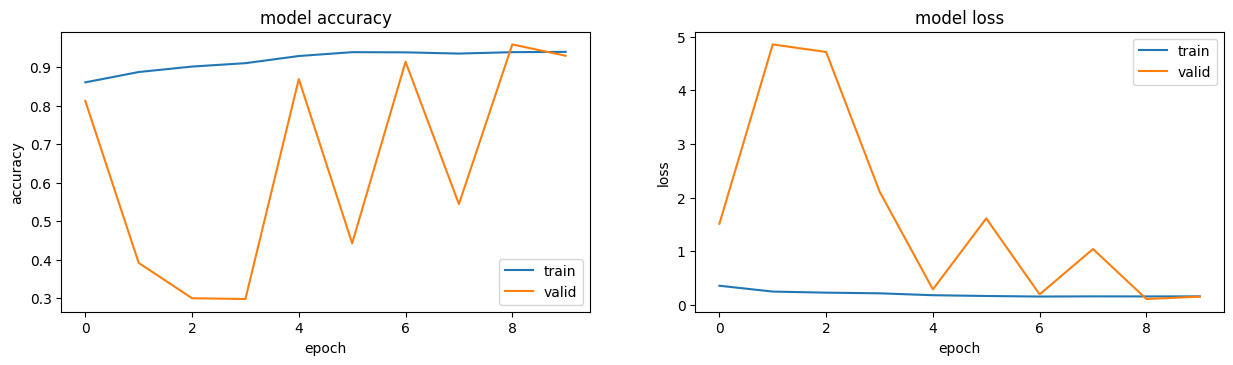

In [ ]:
plt.figure(1, figsize = (15,8))

plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

# **Evaluation and Predicting**

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator )
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 345ms/step - accuracy: 0.9371 - loss: 0.1857
Test Loss: 0.12885639071464539
Test Accuracy: 0.958984375


In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 293ms/step


# **Classification report**

In [ ]:
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)


              precision    recall  f1-score   support

      NORMAL       0.85      0.90      0.88        84
   PNEUMONIA       0.98      0.97      0.98       428

    accuracy                           0.96       512
   macro avg       0.92      0.94      0.93       512
weighted avg       0.96      0.96      0.96       512



# **Confusion matrix**

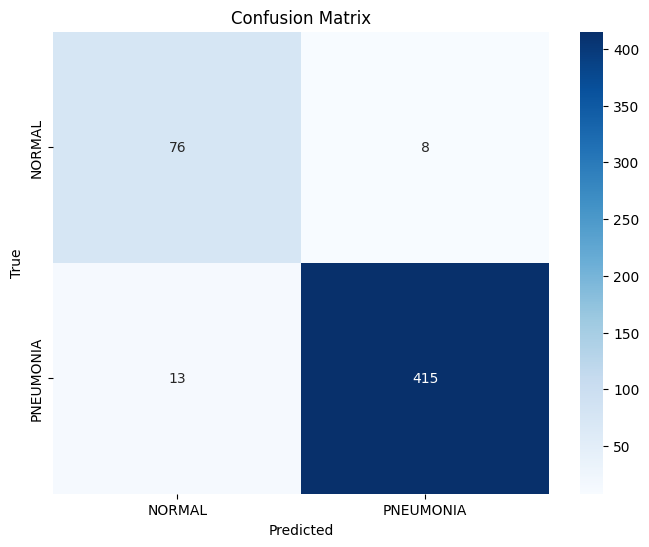

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# **AUC and ROC**

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc}")


AUC: 0.9791666666666666


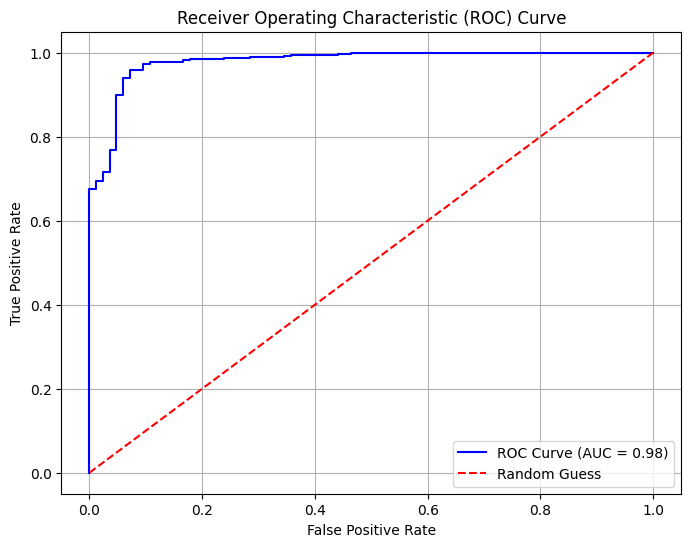

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
